# Project 2  Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling (20 pts)


**Resources:**
- LDA:
    - https://medium.com/sayahfares19/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06 
    - https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim#%F0%9F%93%9A-Topic-Modeling (code for previous post)
    - https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf/ 
- BERTopic:
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_documents.html#visualize-documents-with-plotly 
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_topics.html 


In [4]:
####################
## MOVE THIS BLOCK TO part03.py
####################

####################
## CALL THIS BLOCK TO part03.py
####################

# from tqdm.auto import tqdm
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

In [5]:
####################
## CALL THIS BLOCK FROM part00_utils_visuals.py
####################

# read in SOTU.csv using pandas, name the variable `sou` for simplicity
# the below cell is what the output should look like

from src import part00_utils_visuals as part00
# import src.part00_utils_visuals as part00

from src import part01

part00.plot_style(style=part00.PLOT_STYLE_SEABORN)

sou = part00.pd.read_csv(part00.DIR_DATA_00_RAW / part00.CSV_SOTU)

In [6]:
sou

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169
...,...,...,...,...
241,George Washington,1791.0,\nFellow-Citizens of the Senate and House of R...,2264
242,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
243,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
244,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069


### LDA

- Train an LDA model with 18 topics
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization

You may use the next two cells to process the data.

In [7]:
import spacy
from tqdm import tqdm
from collections import Counter

spacy.cli.download("en_core_web_sm")

nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 67.6 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
####################
## MOVE THIS BLOCK TO part03.py
####################

####################
## CALL THIS BLOCK TO part03.py
####################

def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [9]:
# Process all texts - note this takes ~ 5 minutes to run
# processed_docs = sou['Text'].apply(preprocess_text)

from tqdm.auto import tqdm
tqdm.pandas()  # registers .progress_apply()

step00_processed_docs = sou['Text'].progress_apply(preprocess_text)


  0%|          | 0/246 [00:00<?, ?it/s]

Example Progress Bar: 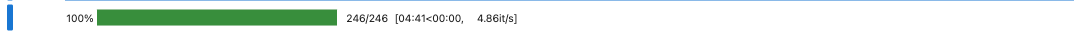)

In [10]:
type(step00_processed_docs), step00_processed_docs

(pandas.core.series.Series,
 0      [speak, president, present, prepared, remark, ...
 1      [president, speaker, point, president, turn, f...
 2      [president, thank, thank, thank, madam, speake...
 3      [president, thank, thank, thank, good, mitch, ...
 4      [president, thank, thank, thank, madam, speake...
                              ...                        
 241    [fellow, citizen, senate, house, representativ...
 242    [fellow, citizen, senate, house, representativ...
 243    [fellow, citizen, senate, house, representativ...
 244    [fellow, citizen, senate, house, representativ...
 245    [fellow, citizen, senate, house, representativ...
 Name: Text, Length: 246, dtype: object)

In [11]:
part01.save_the_processed_data_to_csv(data=step00_processed_docs, filepath=part00.DIR_DATA_03_LDA_BERT / "step00_processed_docs.csv")

To train an LDA model, use the LdaModel function that we imported a couple of cells back. The last resource linked under the LDA section is especially useful for walking through the steps we have below. *Note: one of the arguments to the LdaModel function is `random_state` which specifies the random seed for reproducibility. Please set yours to 42. Further, the last resource provided uses `LdaMulticore` which is essentially a parallelizable version of our function `LdaModel`. Use `LdaModel` instead, but the usage will be similar, except you can ignore the `iterations` and `workers` arguments..*.

In [12]:
# processed_docs = read_csv(...)

import ast

step01_processed_docs_from_csv = part00.pd.read_csv(part00.DIR_DATA_03_LDA_BERT / "step00_processed_docs.csv")
step01_processed_docs_from_csv = step01_processed_docs_from_csv["Text"]
step01_processed_docs_from_csv = step01_processed_docs_from_csv.apply(ast.literal_eval)
type(step01_processed_docs_from_csv), step01_processed_docs_from_csv

(pandas.core.series.Series,
 0      [speak, president, present, prepared, remark, ...
 1      [president, speaker, point, president, turn, f...
 2      [president, thank, thank, thank, madam, speake...
 3      [president, thank, thank, thank, good, mitch, ...
 4      [president, thank, thank, thank, madam, speake...
                              ...                        
 241    [fellow, citizen, senate, house, representativ...
 242    [fellow, citizen, senate, house, representativ...
 243    [fellow, citizen, senate, house, representativ...
 244    [fellow, citizen, senate, house, representativ...
 245    [fellow, citizen, senate, house, representativ...
 Name: Text, Length: 246, dtype: object)

In [13]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches
step02_build_dict_from_processed_docs = Dictionary(step01_processed_docs_from_csv)
step02_build_dict_from_processed_docs;

In [14]:
step03_corpus = [doc for doc in step01_processed_docs_from_csv]
step03_corpus = [step02_build_dict_from_processed_docs.doc2bow(doc) for doc in step01_processed_docs_from_csv]
step03_corpus;

In [15]:
# train LDA model with 18 topics

NUM_OF_TOPICS      = 18
RANDOM_SEED_NUM    = 42
NUM_OF_PASSES      = 10
PROGRESS_FREQUENCY = 0 # batch learning

lda_model = LdaModel(
    corpus=step03_corpus,
    id2word=step02_build_dict_from_processed_docs,
    num_topics=NUM_OF_TOPICS,
    random_state=RANDOM_SEED_NUM,
    passes=NUM_OF_PASSES,
    update_every=PROGRESS_FREQUENCY,
)
lda_model

In [16]:
# print the top 10 words for each topic
NUM_OF_TOP_N_TOPICS = 10

print(f"--- Top LDA topics. ---")
for idx, topic in lda_model.print_topics(num_words=NUM_OF_TOP_N_TOPICS):
    print(f"Topic: {idx} \nWords: {topic}\n")

--- Top LDA topics. ---
Topic: 0 
Words: 0.013*"states" + 0.013*"government" + 0.009*"united" + 0.008*"congress" + 0.007*"country" + 0.006*"year" + 0.006*"public" + 0.006*"great" + 0.005*"state" + 0.005*"power"

Topic: 1 
Words: 0.002*"year" + 0.002*"people" + 0.002*"government" + 0.001*"states" + 0.001*"congress" + 0.001*"country" + 0.001*"nation" + 0.001*"great" + 0.001*"time" + 0.001*"united"

Topic: 2 
Words: 0.003*"year" + 0.003*"government" + 0.002*"states" + 0.002*"congress" + 0.002*"united" + 0.002*"people" + 0.002*"great" + 0.002*"service" + 0.002*"public" + 0.001*"increase"

Topic: 3 
Words: 0.015*"year" + 0.011*"world" + 0.011*"people" + 0.011*"america" + 0.010*"nation" + 0.007*"help" + 0.007*"congress" + 0.007*"american" + 0.007*"work" + 0.006*"time"

Topic: 4 
Words: 0.009*"isthmus" + 0.006*"colombia" + 0.005*"government" + 0.004*"states" + 0.004*"panama" + 0.004*"united" + 0.004*"colombian" + 0.004*"treaty" + 0.003*"year" + 0.003*"congress"

Topic: 5 
Words: 0.003*"year" 

In [17]:
# lda_model.print_topics(-1)

In [18]:
# print the topic distribution for the first speech
# Where does a text belong to

# step04_topic_dist_first_speech = lda_model[step03_corpus[0]]
step04_topic_dist_first_speech = lda_model[step03_corpus][0]
step04_topic_dist_first_speech

[(7, np.float32(0.9997309))]

In [19]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()

In [20]:
pyLDAvis.gensim_models.prepare(lda_model, step03_corpus, step02_build_dict_from_processed_docs)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.162521 -0.126311       1        1  35.438083
6      0.157323 -0.060432       2        1  25.787725
10     0.178967  0.028782       3        1  13.735866
3      0.202841  0.134162       4        1  12.638032
7      0.168056  0.166615       5        1   7.052381
8      0.155744 -0.155774       6        1   5.078049
16     0.000794  0.007825       7        1   0.169912
17    -0.053576  0.027428       8        1   0.029613
9     -0.058696 -0.027552       9        1   0.027767
4     -0.041461 -0.041372      10        1   0.024963
12    -0.061192 -0.032978      11        1   0.005718
1     -0.128475  0.030088      12        1   0.001699
2     -0.057389  0.009090      13        1   0.001699
5     -0.115087  0.007610      14        1   0.001699
13    -0.091102  0.005346      15        1   0.001699
11    -0.125912 -0.003683      16        1   0.001699
15    -0.136505  0.010673      17        1   0.001699
14    -0.156851  0.020482      18        1   0.001699, topic_info=            Term         Freq        Total Category  logprob  loglift
1525  government  8290.000000  8290.000000  Default  30.0000  30.0000
1066      states  6520.000000  6520.000000  Default  29.0000  29.0000
1250        year  7007.000000  7007.000000  Default  28.0000  28.0000
223     congress  5396.000000  5396.000000  Default  27.0000  27.0000
1185      united  5054.000000  5054.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
141     business     0.005015  1490.473949  Topic18  -7.9191  -1.6192
1009     service     0.005552  2173.415605  Topic18  -7.8174  -1.8947
1417  department     0.005227  1752.772929  Topic18  -7.8778  -1.7400
801        peace     0.005108  1994.063468  Topic18  -7.9008  -1.8920
5000     subject     0.005067  1983.383843  Topic18  -7.9089  -1.8947

[1383 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
9256      4  0.982066  --to
9084      4  0.984218  --we
9111      1  0.814738  1791
9111      4  0.101842  1791
9111      6  0.101842  1791
...     ...       ...   ...
1250      5  0.100321  year
1250      6  0.027114  year
1250      7  0.000571  year
1250      8  0.000143  year
1250     10  0.000143  year

[2020 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 11, 4, 8, 9, 17, 18, 10, 5, 13, 2, 3, 6, 14, 12, 16, 15])

In [21]:
# print the topic distribution for the first speech

SPEECH_ID = 0

step05_first_speech_bow = step03_corpus[SPEECH_ID]
step05_first_speech_bow;

step06_first_speech_topics = lda_model.get_document_topics(bow=step05_first_speech_bow)

for topic_id, prob in step06_first_speech_topics:
    print(f"Topic {topic_id}: {prob}")

Topic 7: 0.9997308850288391


### BERTopic

- Train a BERTopic model with a `min_topic_size` of 3 *Hint: use `BERTopic` to instantiate the model and specify `min_topic_size` in here. Actually fit the model using `fit_transform`, which `docs` passed into this.*
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization of the topics (see topic_model.visualize_topics())

In [22]:
docs = sou['Text'].to_list()
docs[0];

In [30]:
# train the model - this takes about 30 seconds
MIN_TOPIC_SIZE = 3
IS_VERBOSE = True

step07_topic_model    = BERTopic(min_topic_size=MIN_TOPIC_SIZE, verbose=IS_VERBOSE)
topics, probabilities = step07_topic_model.fit_transform(docs)

2025-11-25 04:27:16,891 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2025-11-25 04:27:28,078 - BERTopic - Embedding - Completed ✓
2025-11-25 04:27:28,079 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-25 04:27:28,406 - BERTopic - Dimensionality - Completed ✓
2025-11-25 04:27:28,407 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-25 04:27:28,417 - BERTopic - Cluster - Completed ✓
2025-11-25 04:27:28,420 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-25 04:27:30,327 - BERTopic - Representation - Completed ✓


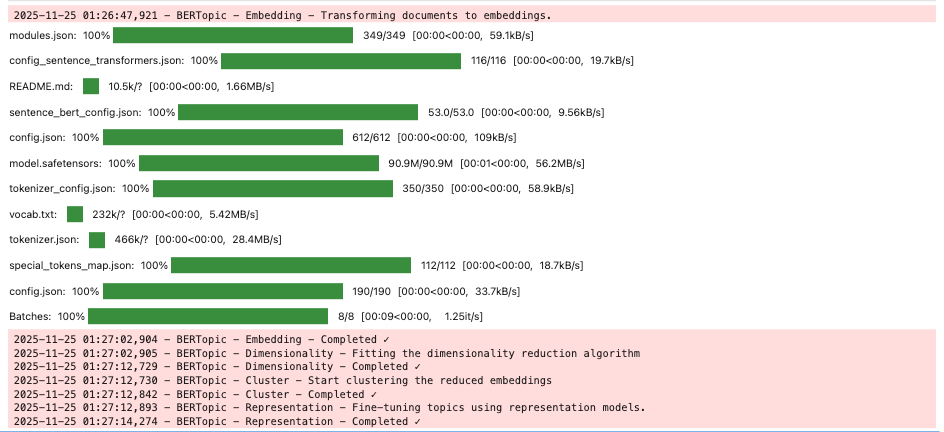

In [24]:
step07_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2,-1_the_of_to_and,"[the, of, to, and, in, is, be, for, that, it]",[\nTo the Senate and House of Representatives:...
1,0,148,0_the_of_to_and,"[the, of, to, and, in, be, that, for, by, it]",[\nTo the Congress of the United States:\nYour...
2,1,96,1_the_and_to_of,"[the, and, to, of, we, in, our, that, for, is]","[\nMr. President, Mr. Speaker, Members of the ..."


In [25]:
step07_topic_model.get_topic(0)


[('the', np.float64(0.1525040353076544)),
 ('of', np.float64(0.12251903155110254)),
 ('to', np.float64(0.08192207992656894)),
 ('and', np.float64(0.0798977120054938)),
 ('in', np.float64(0.0618824709907749)),
 ('be', np.float64(0.04266770579643109)),
 ('that', np.float64(0.040612991931407105)),
 ('for', np.float64(0.037245425671863626)),
 ('by', np.float64(0.03662446576166183)),
 ('it', np.float64(0.034849497077768875))]

In [37]:
# remove stop words from the topics (Hint: use CountVectorizer and then .update_topics on topic_model)

LANG="english"

step08_vectorizer_model = CountVectorizer(stop_words=LANG)
step07_topic_model.update_topics(docs, topics=topics, vectorizer_model=step08_vectorizer_model)


2025-11-25 04:33:50,835 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [38]:
# output the top 10 words for each topic - hint see get_topic_info

step09_topic_info = step07_topic_model.get_topic_info()
step09_topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,34,-1_government_states_united_congress,"[government, states, united, congress, year, w...",[\nFellow Citizens of the Senate and of the Ho...
1,0,90,0_world_america_new_people,"[world, america, new, people, years, american,...","[\nMr. President, Mr. Speaker, Members of the ..."
2,1,30,1_states_united_government_congress,"[states, united, government, congress, public,...",[\nTo the Senate and House of Representatives:...
3,2,13,2_states_united_government_public,"[states, united, government, public, congress,...",[\nFellow-Citizens of the Senate and House of ...
4,3,12,3_states_government_united_congress,"[states, government, united, congress, country...",[\nFellow-Citizens of the Senate and of the Ho...
5,4,9,4_government_great_work_law,"[government, great, work, law, public, congres...",[\nTo the Senate and House of Representatives:...
6,5,8,5_government_states_law_united,"[government, states, law, united, gold, congre...",[\nTo the Senate and House of Representatives:...
7,6,7,6_government_states_public_general,"[government, states, public, general, united, ...",[\nFellow-Citizens of the Senate and House of ...
8,7,7,7_states_government_world_united,"[states, government, world, united, great, new...","[\nMr. President, Mr. Speaker, Members of the ..."
9,8,5,8_states_government_public_congress,"[states, government, public, congress, united,...",[\nTo the Senate and House of Representatives ...


In [ ]:
topics, probabilities = step07_topic_model.fit_transform(docs)

In [42]:
# output the topic distribution for the first speech
# hint: check out approximate_distribution() and visualize_distribution()
###
# references:
# 1. https://maartengr.github.io/BERTopic/getting_started/distribution/distribution.html
#
# topic_distr, _ = topic_model.approximate_distribution(docs)
# topic_model.visualize_distribution(topic_distr[1])
###

topic_distribution, _ = step07_topic_model.approximate_distribution(docs)

100%|██████████| 1/1 [00:13<00:00, 13.56s/it]


In [47]:
topic_distribution.shape

(246, 16)

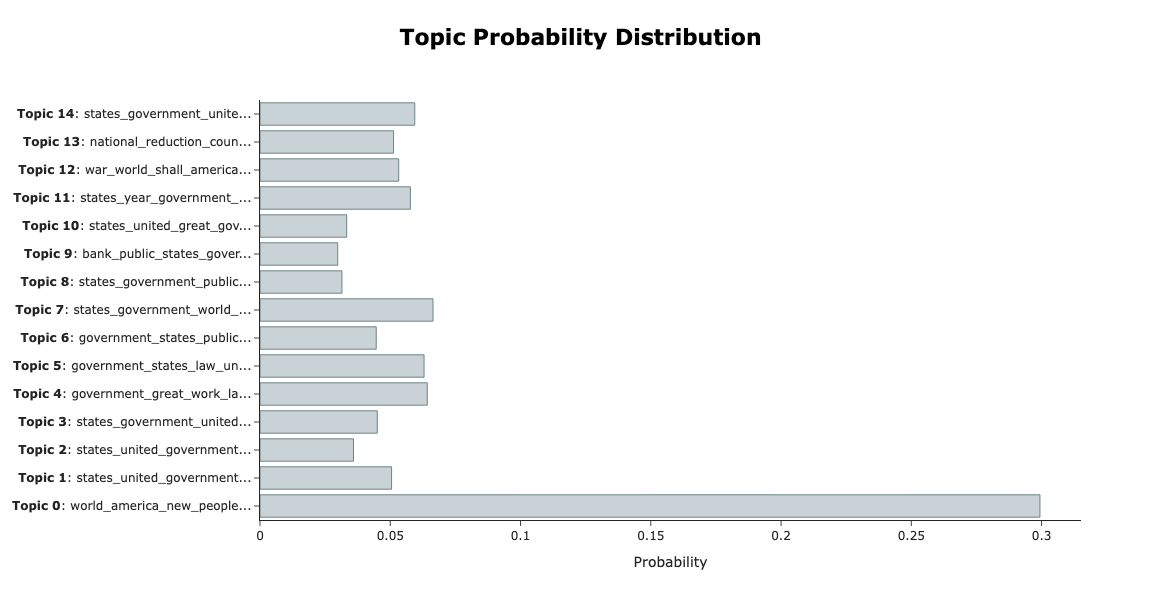

In [50]:
DOC_ROW_ID = 0

step07_topic_model.visualize_distribution(topic_distribution[DOC_ROW_ID])

In [52]:
import ipywidgets as widgets

@widgets.interact(DOC_ROW_ID=(0, len(topic_distribution)-1))
def show(DOC_ROW_ID=0):
    return step07_topic_model.visualize_distribution(topic_distribution[DOC_ROW_ID])

interactive(children=(IntSlider(value=0, description='DOC_ROW_ID', max=245), Output()), _dom_classes=('widget-…

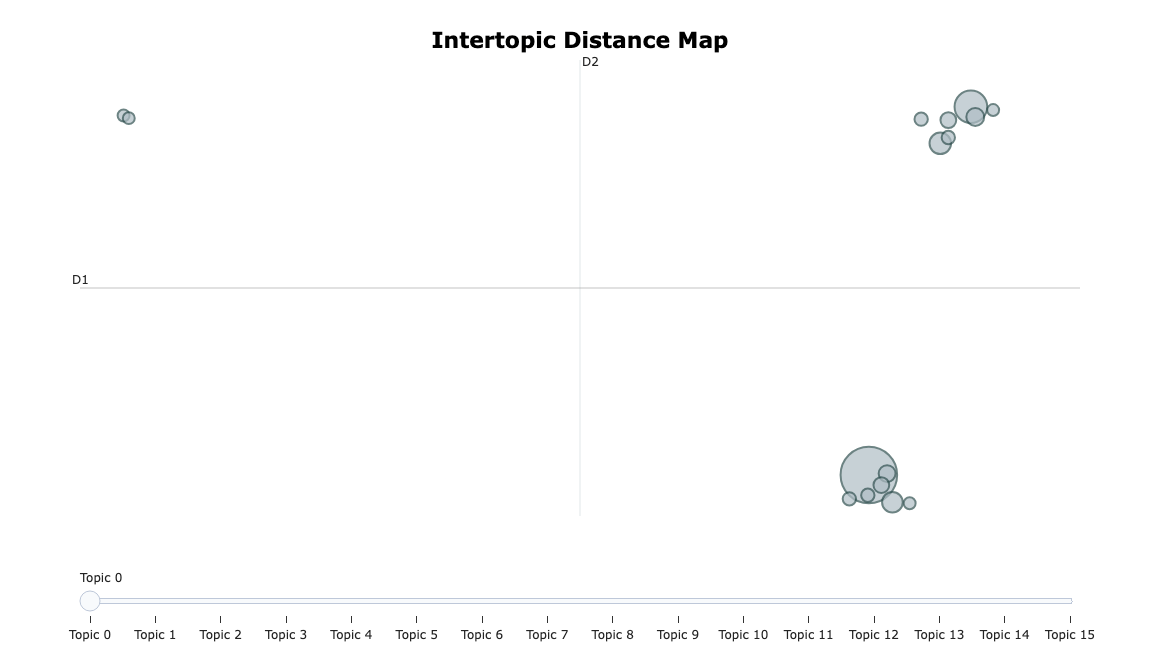

In [40]:
# run this cell to visualize the topics
step07_topic_model.visualize_topics()